<a href="https://colab.research.google.com/github/alekstoteles/UCB/blob/master/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Tree Practice
Alexander Müller

## Imports and settings

In [0]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import graphviz
import pydot
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn import tree
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [0]:
plt.rcParams['figure.figsize'] = [10, 10]

## PIMA Indian Diabetes Dataset

- This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.
- The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.
  - `Pregnancies`: Number of times pregnant
  - `Glucose`: Plasma glucose concentration over 2 hours in an oral glucose tolerance test
  - `BloodPressure`: Diastolic blood pressure (mm Hg)
  - `SkinThickness`: Triceps skin fold thickness (mm)
  - `Insulin`: 2-Hour serum insulin (mu U/ml)
  - `BMI`: Body mass index (weight in kg/(height in m)2)
  - `DiabetesPedigreeFunction`: Diabetes pedigree function (a function which scores likelihood of diabetes based on family history)
  - `Age`: Age (years)
  - `Outcome`: Class variable (0 if non-diabetic, 1 if diabetic)

### Data ingestion

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
# import data as pandas dataframe
data_path = '/gdrive/My Drive/ML_playground/data/diabetes.csv'
diabetes = pd.read_csv(data_path, delimiter=',')

### Exploratory data analysis

In [0]:
# show first few entries - only continuous, no categorical variables
diabetes.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [0]:
# check for nan values
diabetes.isna().values.any()

False

In [0]:
# show descriptive statistics of diabetes data
diabetes.describe().round(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00,768.00
mean,3.85,120.89,69.11,20.54,79.80,31.99,0.47,33.24,0.35
std,3.37,31.97,19.36,15.95,115.24,7.88,0.33,11.76,0.48
min,0.00,0.00,0.00,0.00,0.00,0.00,0.08,21.00,0.00
25%,1.00,99.00,62.00,0.00,0.00,27.30,0.24,24.00,0.00
50%,3.00,117.00,72.00,23.00,30.50,32.00,0.37,29.00,0.00
75%,6.00,140.25,80.00,32.00,127.25,36.60,0.63,41.00,1.00
max,17.00,199.00,122.00,99.00,846.00,67.10,2.42,81.00,1.00


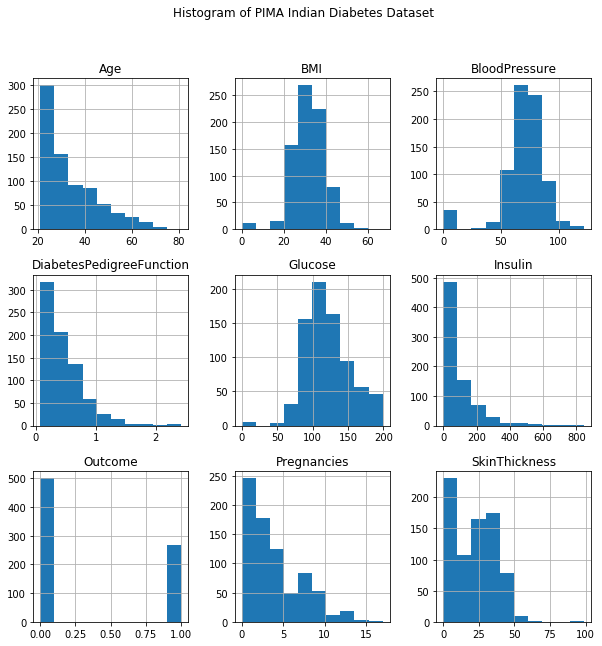

In [0]:
# plot histograms
diabetes.hist()
plt.suptitle("Histogram of PIMA Indian Diabetes Dataset")
pass

In [0]:
# show correlation (Pearson's r) for outcome variable - Glucose, BMI and age seem to be particularly interesting
diabetes.corr()['Outcome'].round(2).sort_values(ascending=False)

Outcome                     1.00
Glucose                     0.47
BMI                         0.29
Age                         0.24
Pregnancies                 0.22
DiabetesPedigreeFunction    0.17
Insulin                     0.13
SkinThickness               0.07
BloodPressure               0.07
Name: Outcome, dtype: float64

### Data preparation for modeling

In [0]:
# select feature vector X (all data frame rows, all columns except "Outcome") and label y (all rows, last column)
Xd, yd = diabetes.iloc[:, : -1], diabetes.iloc[:,-1]
print("Shape of feature vector: {}".format(Xd.shape))
print("Shape of target variable: {}".format(yd.shape))

Shape of feature vector: (768, 8)
Shape of target variable: (768,)


In [0]:
# split data into training set and test set
Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd,yd, test_size=0.3, random_state = 42)
print("Split dataset into {} train and {} test cases".format(len(yd_train), len(yd_test)))

Split dataset into 537 train and 231 test cases


### Baseline: Single decision tree

#### Mathematical formulation

**Decision tree - Background (Source: Breiman, 1984; Hastie, 2009)**

- Given training vectors $x_i \epsilon R^n, i=1,…, l$ and a label vector $y \epsilon R^l$, a decision tree recursively partitions the space such that the samples with the same labels are grouped together.

- Let the data at node $m$ be represented by $Q$. For each candidate split $\theta = (j, t_m)$ consisting of a feature $j$ and threshold $t_m$, partition the data into $Q_{left}(\theta)$ and $Q_{right}(\theta)$ subsets

$$Q_{left}(\theta)= (x, y)|x_j \leq t_m$$

$$Q_{right} (\theta)= Q \setminus Q_{left}(\theta)$$

- The impurity at $m$ is computed using an impurity function $H()$, the choice of which depends on the task being solved (classification or regression)

$$G(Q, \theta) = \frac{n_{left}}{N_m} H(Q_{left}(\theta)) + \frac{n_{right}}{N_m} H(Q_{right}(\theta))$$

- Select the parameters that minimise the impurity

$$\theta^* = argmin_{\theta} \ G(Q, \theta)$$

- Recurse for subsets $Q_{left}(\theta^*)$ and $Q_{right}(\theta^*)$ until the maximum allowable depth is reached, $N_m<min_{samples}$ or $N_m = 1$.


**Common measures of impurity**

- If the target is a classification outcome taking on values $0,1,...K-1$, for node $m$, representing a region $R_m$ with $N_m$ observations, let $p_{mk} = 1/N_m \sum_{x_i \epsilon R_m} I(y_i = k)$ be the proportion of class $k$ observations in node $m$

  - Gini
$$H(X_m) = \sum_k p_{mk}(1-p_{mk})$$

  - Entropy
$$H(X_m) = -\sum_k p_{mk}log(p_{mk})$$

- where $X_m$ is the training data in node $m$


#### Modeling and evaluation

In [0]:
# instantiate decision tree classifier with impurity measure 'entropy' and regularization parameters 
# (e.g. max_depth, min_samples_split, max_leaf_nodes, min_samples_leaf)
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, 
                                  random_state=42, min_samples_split=10,
                                  max_leaf_nodes=10, min_samples_leaf=10)
clf_tree = clf.fit(Xd_train, yd_train)

In [0]:
# make predictions on test set
yd_pred_tree = clf_tree.predict(Xd_test)

# evaluate predictions
accuracy_single_tree = accuracy_score(yd_test, yd_pred_tree)
print("Accuracy of single tree classifier: {:.2f}%".format(accuracy_single_tree * 100))

Accuracy of single tree classifier: 76.62%


**Accuracy metric**

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

In [0]:
print("F1 score of single tree: {:.2f}%".format(f1_score(yd_test, yd_pred_tree)*100))

F1 score of single tree: 62.50%


**F1 score metric**

$$F1 score = \frac{precision * recall}{precision + recall}$$

with

$$precision = \frac{TP}{TP + FP}$$

$$recall = \frac{TP}{TP + FN}$$

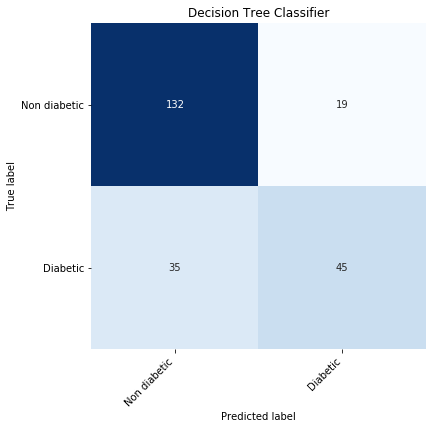

In [0]:
# print confusion matrix
def print_confusion_matrix(conf_matrix, class_names, title):
  df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
  fig, ax = plt.subplots(figsize=(6, 6))
  heatmap = sns.heatmap(df_cm, cmap="Blues", annot=True, cbar=False, fmt='g')
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  plt.title(title)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return

class_names=['Non diabetic', 'Diabetic']
print_confusion_matrix(confusion_matrix(yd_test, yd_pred_tree), class_names, 
                       "Decision Tree Classifier")

* High false negative rate (impact on metric "recall / sensitivity")

#### Visualize decision tree

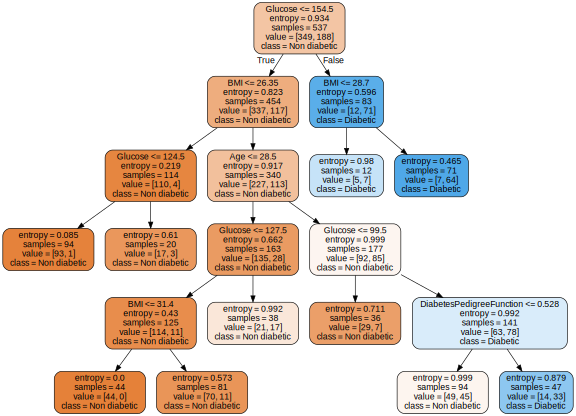

In [0]:
dot_data= tree.export_graphviz(clf_tree, out_file=None, filled=True, rounded=True,
                               feature_names=diabetes.columns[:-1], 
                               class_names=['Non diabetic', 'Diabetic'])
# graph = graphviz.Source(dot_data) 

pdot = pydot.graph_from_dot_data(dot_data)
pdot[0].set_graph_defaults(size = "\"8,10\"")
graph = graphviz.Source(pdot[0].to_string())
graph


Explanation of graph:
* Entropy: entropy function for split of # of samples (entropy function reaches its maximum at the point of maximum impurity, i.e. 0.5 in a uniform distribution between 0 and 1).
* Value: split of # samples of each node into the two classes (example: [349, 188] means that 349 samples are labeled "non diabetic", 188 are "diabetic" --> the predicted class for this node is the majority class).
* Color indicates majority class


Findings:
* Most frequent splits on `Glucose` and `BMI`.
* Some splits on the deeper levels do not contribute to classification result (e.g. left part of decision tree mostly "non diabetic"), but serve to further differentiate the decision boundaries within that feature, with impact on the predicted probabilities for specific samples.
* `DiabetesPedigreeFunction` is added as additional feature (bottom right) for samples with Glucose between 99-154 and age >28, but still high entropy in those nodes --> further splits possible
* Overview below shows the relative feature importances of the decision tree

In [0]:
# output feature importances of decision tree (add up to 1)
print('Feature importances of decision tree')
rounder = lambda x: np.round(x, 2)
print(*list(zip(diabetes.columns, rounder(clf_tree.feature_importances_))), sep='\n')

Feature importances of decision tree
('Pregnancies', 0.0)
('Glucose', 0.58)
('BloodPressure', 0.0)
('SkinThickness', 0.0)
('Insulin', 0.0)
('BMI', 0.25)
('DiabetesPedigreeFunction', 0.02)
('Age', 0.14)


The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature (=entropy reduction, i.e. information gain).

#### Output predicted probabilities for a single sample

In [0]:
# output feature vector of a given sample
Xd_test.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
668,6,98,58,33,190,34.0,0.43,43


In [0]:
# output class label for a given sample [0=non diabetic, 1=diabetic]
yd_test.head(1)

668    0
Name: Outcome, dtype: int64

In [0]:
# output predicted class probabilities of given sample [non-diabetic, diabetic]
# The predicted class probability is the fraction of samples of the same class in a leaf,
# in this case 29/36 = 0.81 --> non diabetic
clf.predict_proba(Xd_test)[0]

array([0.80555556, 0.19444444])

### Random forest classification in sklearn

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [0]:
# instantiate random forest classifier
clf_rf = RandomForestClassifier(criterion='entropy', n_estimators=100, 
                                max_depth=5, random_state=42)
clf_rf.fit(Xd_train, yd_train)

# make predictions on test set
yd_pred_rf = clf_rf.predict(Xd_test)

# evaluate predictions
accuracy_rf = accuracy_score(yd_test, yd_pred_rf)
print("Accuracy of random forest classifier: {:.2f}%".format(accuracy_rf * 100))
print("F1 score of random forest classifier: {:.2f}%".format(f1_score(yd_test, yd_pred_rf)*100))

Accuracy of random forest classifier: 75.76%
F1 score of random forest classifier: 63.16%


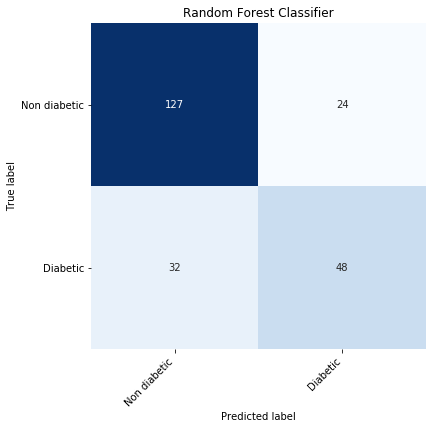

In [0]:
# print confusion matrix for random forest classifier
print_confusion_matrix(confusion_matrix(yd_test, yd_pred_rf), class_names,
                      "Random Forest Classifier")

In [0]:
# output feature importances of random forest (add up to 1)
print('Feature importances of random forest')
print(*list(zip(diabetes.columns, rounder(clf_rf.feature_importances_))), sep='\n')

Feature importances of random forest
('Pregnancies', 0.07)
('Glucose', 0.36)
('BloodPressure', 0.06)
('SkinThickness', 0.05)
('Insulin', 0.06)
('BMI', 0.19)
('DiabetesPedigreeFunction', 0.07)
('Age', 0.15)


Compared to the single decision tree, the feature importances are much more balanced (less dependent on `Glucose` feature), which might generalize better to new data.

### Gradient boosted trees using XGBoost in Python

[XGBoost](https://arxiv.org/pdf/1603.02754.pdf) (Extreme Gradient Boosting) belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core. It is an optimized distributed gradient boosting library.

Boosting is a sequential technique which works on the principle of an ensemble. It combines a set of weak learners and delivers improved prediction accuracy. At any instant t, the model outcomes are weighed based on the outcomes of previous instant t-1. The outcomes predicted correctly are given a lower weight and the ones misclassified are weighted higher. 

Features of XGBoost:
- Speed and performance : Originally written in C++, it is comparatively faster than other ensemble classifiers.
- Core algorithm is parallelizable : Because the core XGBoost algorithm is parallelizable it can harness the power of multi-core computers. It is also parallelizable onto GPU’s and across networks of computers making it feasible to train on very large datasets as well.
- Consistently outperforms other algorithm methods : It has shown better performance on a variety of machine learning benchmark datasets.
- Wide variety of tuning parameters : XGBoost internally has parameters for cross-validation, regularization, user-defined objective functions, missing values, tree parameters, scikit-learn compatible API etc.

Note on 'random forests':
* Practically, XGBoost is *not* a random forest algorithm, because it build trees one at a time, where each new tree helps to correct errors made by previously trained tree. 
* Random forests train each tree independently, using a random sample of the data.

#### XGBoost basics

**Regression Tree Model**

- Regression tree is a function $f_k$  that maps the attributes $x_i$ to the scores $y$.
- Assume we have $K$ trees to predict the score $\hat{y}_i$
$$\hat{y}_i = \sum_{k=1}^{K}f_k(x_i), f_k \epsilon F$$
  - with $F$ being the space of functions containing all regression trees
- Parameters of $f_k$:
  - structure of each tree
  - score in the leafs

**Learning objectives**

- Objective function for parameter set $\theta$
$$Obj(\theta) = L(\theta) + R(\theta)$$

- Loss (how well model fits training data)
$$L = \sum_{i=1}^{n} l(y_i, \hat{y}_i)$$

  - $L$ is a differentiable convex loss function that measures the difference 
between the prediction $\hat{y_i}$ and the target $y$.
  - Squared loss: $l(y_i, \hat{y}_i) = (y_i - \hat{y}_i)^2$ --> common gradient boosting machine for regression problem
  - Logistic loss: $l(y_i, \hat{y}_i) = y_i \ln{(1+e^{-\hat{y}_i}}) + (1-y_i) \ln{(1 + e^{\hat{y}_i})}$ --> for binary classification problem

- Regularization (reduce complexity of model --> smooth final learnt weights to avoid overfitting)
  - L1 norm (lasso): $R(w) = \lambda||w||_1$ (adds absolute value of magnitude of coefficient as penalty term to the loss function)
  - L2 norm (ridge): $R(w) = \lambda ||w||^2$ (penalizes sum of squared coefficients)
  - $\lambda$ is the regularization penalty
  - The key difference between these techniques is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features. Ridge tries to utilize as many features as possible (unbalanced feature weights are penalized through squaring), trying to achieve better generalization.
  - Other ways to regularize: restrict number of nodes in the tree, max. depth

- Objective vs. heuristic
  - Decision trees are usually created using heuristics (e.g. split by information gain)
  - Most heuristics map well to objectives
    - Information gain --> training loss
    - Smoothing leaf values --> L1 or L2 regularization on leaf values
-Instead of applying splits of trees using 'information gain', XGBoost directly optimizes the loss through a construction of an ensemble of trees. In each step, the algorithm searches for a tree which corrects the prediction of the previous tree the most.


**Learning through additive boosting**

  - Start with a prediction from tree
  - For every following iteration $t$ and every $i$-th instance prediction $\hat{y_i}^{(t)}= \hat{y_i}^{(t-1)}+f_t(x_i)$, we need to find $f_t$ to minimize the residual loss
    - Take Taylor expansion of the objective (e.g. squared loss) and calculate gradient statistics 
    - For a fixed tree structure, calculate optimal weights and the resulting change in loss (e.g. by adding an additional leaf)
    - 'Greedy' approach: for each step, add the best branch and from there on just iterativly improve the tree (e.g. by adding further branches)
    


**How to split trees**

- Start from tree with depth 0
- For each leaf node, try to add a split
  - Left to right scan over sorted instances to decide best split among each feature
  - Measure loss reduction after adding the split ("Gain")
$$Gain = \frac{1}{2} [\frac{G^2_L}{H_L + \lambda} + \frac{G^2_R}{H_R + \lambda} - \frac{(G_L + G_R )^2}{H_L + H_R + \lambda}] - \gamma$$

    - with $G$ and $H$ being the gradient statistics of instance sets of left ($G_L$) and right ($G_R$) nodes after the split
    - and $\gamma$ the cost of introducing a new leaf
    - and $\lambda$ the penalty term on the weights

#### Modeling (XGBoost)

*XGBoost hyperparameter settings*


- `learning_rate`: step size shrinkage used to prevent overfitting. After each boosting step, we can directly get the weights of new features, and the learning rate shrinks the feature weights to make the boosting process more conservative. Range is [0,1]
- `max_depth`: determines how deeply each tree is allowed to grow during any boosting round.
- `subsample`: percentage of samples used per tree. Low value can lead to underfitting.
- `colsample_bytree`: percentage of features used per tree. High value can lead to overfitting.
- `n_estimators`: number of trees you want to build.
- `objective`: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.


*XGBoost regularization parameters*

- `gamma`: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
-  `alpha`: L1 regularization on leaf weights. A large value leads to more regularization.
- `lambda`: L2 regularization on leaf weights and is smoother than L1 regularization.

In [0]:
# instantiate xgb random forest classifier with 100 trees
# regularization: max depth = 5, 30% of features used per tree, L1 regularization
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, max_depth=5, 
                          colsample_bytree=0.3,learning_rate=0.1, alpha=10, 
                          eval_metric='error', random_state=42)
model.fit(Xd_train, yd_train)
print(model)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='error',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


#### Explanation of objective function: Binary logistic regression
* Given a model output $z$, the logistic function outputs a probability estimate $\hat{p}$ between 0 and 1:

$$\hat{p} = \sigma(z) = \frac{1}{1+e^{-z}}$$

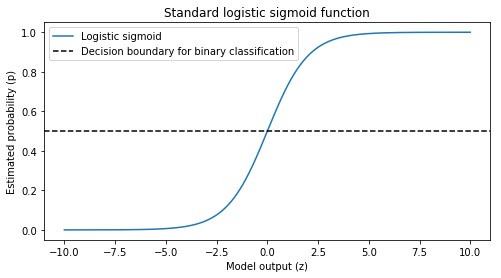

In [0]:
# plot logistic sigmoid function
zvals = np.arange(-10, 10, 0.01)
logistic = lambda x: 1/(1+np.exp(-x))
pvals = logistic(zvals)
fig, ax = plt.subplots(figsize=(8, 4))
plt.title("Standard logistic sigmoid function")
plt.plot(zvals, pvals, label="Logistic sigmoid")
plt.xlabel("Model output (z)")
plt.ylabel("Estimated probability (p)")
plt.axhline(y=0.5, color='k', linestyle='dashed', 
            label="Decision boundary for binary classification")
plt.legend()
pass

**Logistic regression cost function**

$$J(\theta) = - \frac{1}{m} \sum_{i=1}^m [y_i \log(\hat{p_i}) + (1-y_i)\log(1-\hat{p_i})]$$

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


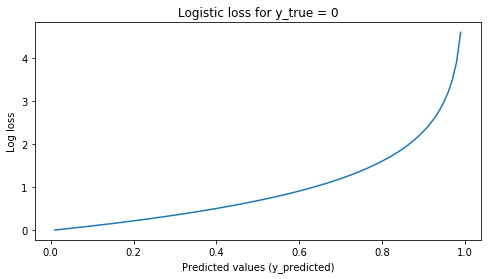

In [0]:
# plotting logistic regression cost function for given y value (parameter "y_true" below)
def logloss(y, y_hat):
  logloss = -(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))
  return logloss
y_true = 0
y_pred = np.arange(0,1, 0.01)
y_logloss = logloss(y_true, y_pred)

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(y_pred, y_logloss)
plt.title("Logistic loss for y_true = {}".format(y_true))
plt.xlabel("Predicted values (y_predicted)")
plt.ylabel("Log loss")
pass

#### Make predictions

In [0]:
# create predictions on test data
yd_pred = model.predict(Xd_test)

In [0]:
# evaluate predictions
accuracy = accuracy_score(yd_test, yd_pred)
print("Accuracy of XGBoost classifier: {:.2f}%".format(accuracy * 100))
print("F1 score of XGBoost classifier: {:.2f}%".format(f1_score(yd_test, yd_pred)*100))

Accuracy of XGBoost classifier: 74.46%
F1 score of XGBoost classifier: 63.80%


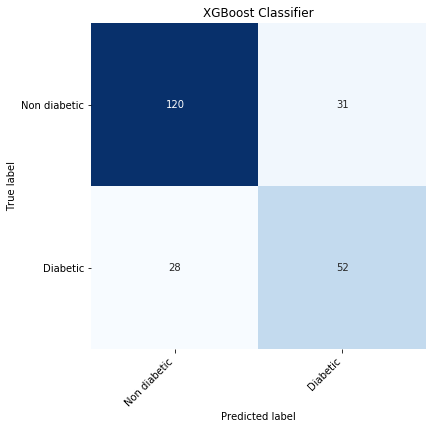

In [0]:
# print confusion matrix for random forest classifier
print_confusion_matrix(confusion_matrix(yd_test, yd_pred), class_names,
                      "XGBoost Classifier")

* Higher sensitivity than single tree, but at the cost of a higher false positive rate.

#### Boosting: K-fold cross-validation using XGBoost

XGBoost allows to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.

Parameters:

- `num_boost_round`: denotes the number of trees to build (analogous to n_estimators)
- `nfolds`: number of cross validation sets
- `early_stopping_rounds`: finishes training of the model early if the hold-out metric ("error" in our case) does not improve for a given number of rounds.


In [0]:
# convert dataset into XGBoost-supported format "DMatrix" (better performance)
data_matrix = xgb.DMatrix(data = Xd, label = yd)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
# dictionary to specify hyperparameters
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}
# specify a 3-fold cross-validation model using the XGBoost cv method and store results in pandas dataframe
cv_results = xgb.cv(dtrain=data_matrix, params=params, nfold=3, num_boost_round=100,
                    early_stopping_rounds=25,metrics="error", as_pandas=True, seed=42)

In [0]:
# recalculate performance metric 'accuracy' ( = 1 - error)
accuracy_hist = pd.DataFrame()
accuracy_hist['train_accuracy'] = 1 - cv_results['train-error-mean']
accuracy_hist['test_accuracy'] = 1 - cv_results['test-error-mean']
accuracy_hist.head(21)

,train_accuracy,test_accuracy
0,0.750000,0.743489
1,0.750000,0.743489
2,0.741537,0.726562
3,0.745443,0.730469
4,0.748698,0.731771
5,0.751953,0.739583
6,0.769531,0.753906
7,0.772135,0.757812
8,0.770833,0.742187
9,0.774089,0.748698


In [0]:
accuracy_hist.tail(21)

,train_accuracy,test_accuracy
46,0.797526,0.763021
47,0.796224,0.761719
48,0.796224,0.761719
49,0.797526,0.761719
50,0.798177,0.761719
51,0.797526,0.763021
52,0.797526,0.763021
53,0.798177,0.763021
54,0.797526,0.765625
55,0.798828,0.765625


In [0]:
# extract and print the final boosting round metric
print("Final boosting round accuracy: \n{}".format(accuracy_hist["test_accuracy"].tail(1)))

Final boosting round accuracy: 
66    0.768229
Name: test_accuracy, dtype: float64


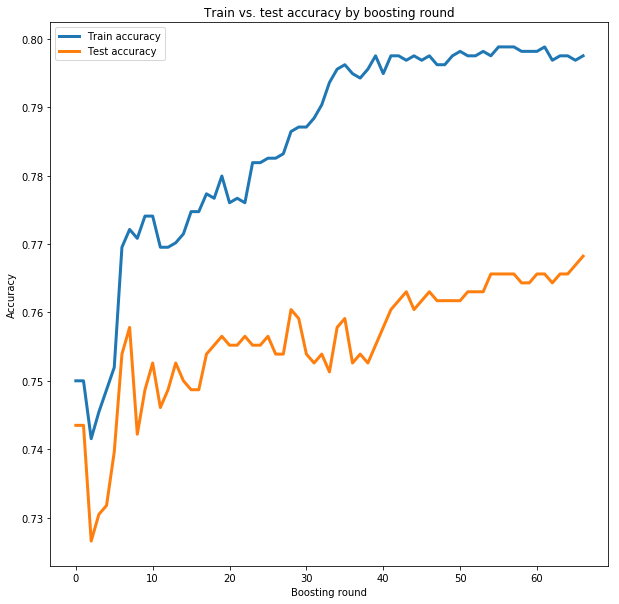

In [0]:
# plot train and test error
train_metric = accuracy_hist['train_accuracy']
test_metric = accuracy_hist['test_accuracy']
plt.plot(train_metric, linewidth=3, label="Train accuracy")
plt.plot(test_metric, linewidth=3, label='Test accuracy')
plt.xlabel("Boosting round")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Train vs. test accuracy by boosting round")
pass

#### Visualize trees

In [0]:
# dictionary to specify hyperparameters
params = {"objective":'binary:logistic', 'max_depth': 5, 'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'alpha': 10}
# train model
xg_clf = xgb.train(params=params, dtrain=data_matrix, num_boost_round=50)

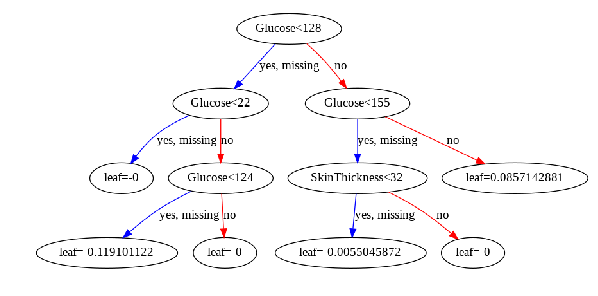

In [0]:
# Show first tree as an example
xgb.plot_tree(xg_clf, num_trees=0)
plt.show()

Each tree contains a continuous score on each of the leaf. For a given example, the decision rules of the tree will be used to classify it into the leaves and calculate the final prediction by summing up the scores in the corresponding leaves (across all trees).
In this classification problem the sum will be passed into the logit function of logistic regression (outputting either 0 or 1).

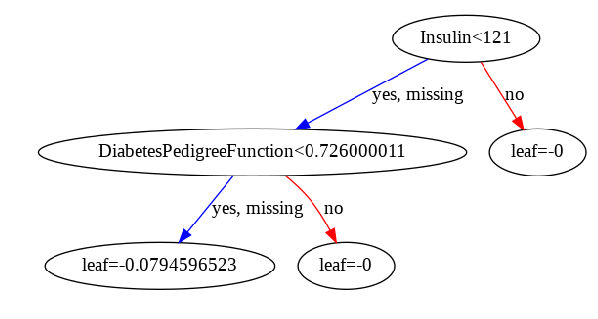

In [0]:
# Show second tree as an example
xgb.plot_tree(xg_clf, num_trees=1)
plt.show()

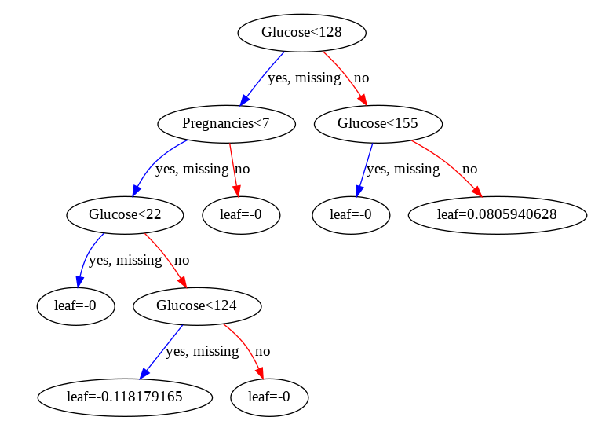

In [0]:
# Show third tree as an example
xgb.plot_tree(xg_clf, num_trees=2)
plt.show()

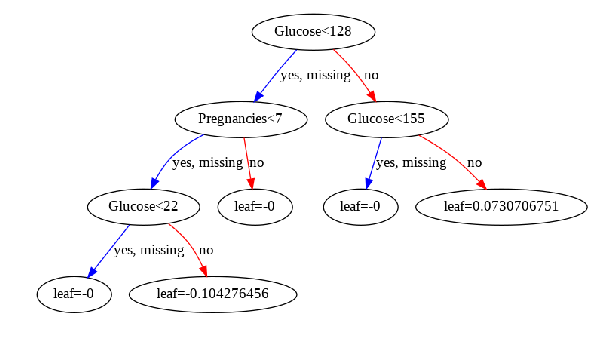

In [0]:
# Show fourth tree as an example
xgb.plot_tree(xg_clf, num_trees=3)
plt.show()

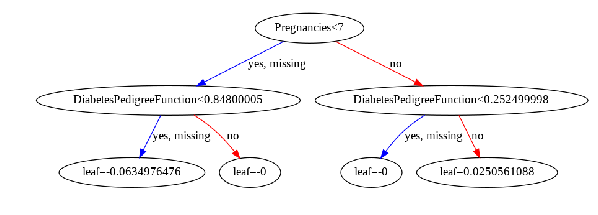

In [0]:
# Show fifth tree as an example
xgb.plot_tree(xg_clf, num_trees=4)
plt.show()

#### Output predicted probabilities for a single sample

In [0]:
# output feature vector of a given sample
Xd_test.head(1)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
668,6,98,58,33,190,34.0,0.43,43


In [0]:
# output class label for a given sample [0=non diabetic, 1=diabetic]
yd_test.head(1)

668    0
Name: Outcome, dtype: int64

In [0]:
# output predicted class probabilities of given sample [non-diabetic, diabetic]
model.predict_proba(Xd_test)[0]

array([0.516779, 0.483221], dtype=float32)

#### Visualize feature importance

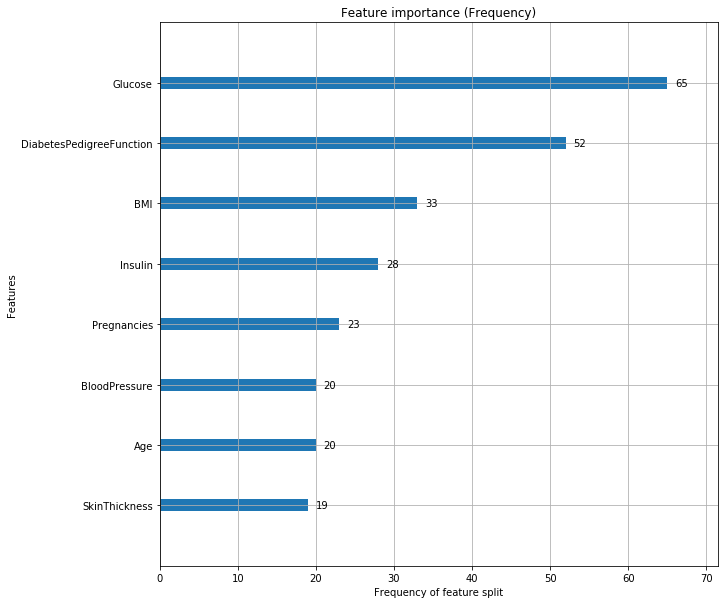

In [0]:
xgb.plot_importance(xg_clf, title="Feature importance (Frequency)", xlabel="Frequency of feature split")
# plt.rcParams['figure.figsize'] = [5, 5]
pass

*Frequency approach:*

Counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they are split on (sum over all trees).
(Note: high split frequency of XGBoost on the DiabetesPedigreeFunction)

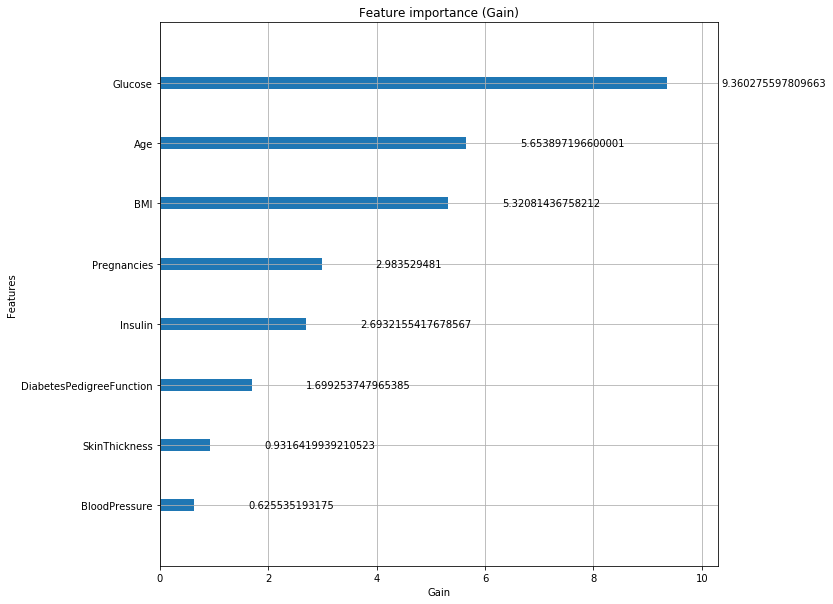

In [0]:
xgb.plot_importance(xg_clf, importance_type='gain', title="Feature importance (Gain)", xlabel='Gain')
pass

*Gain approach:*

Calculating the relative loss improvement (gain) of each feature on each non-terminal node of the boosted trees, and summing up.

### Classification report for all decision tree algorithms

In [0]:
# print classification report for decision tree
target_names = ['Non diabetic', 'Diabetic']
print('Single decision tree - Classification report')
print(classification_report(yd_test, yd_pred_tree, target_names=target_names))

Single decision tree - Classification report
              precision    recall  f1-score   support

Non diabetic       0.79      0.87      0.83       151
    Diabetic       0.70      0.56      0.62        80

    accuracy                           0.77       231
   macro avg       0.75      0.72      0.73       231
weighted avg       0.76      0.77      0.76       231



In [0]:
print('Random Forest - Classification report')
print(classification_report(yd_test, yd_pred_rf, target_names=target_names))

Random Forest - Classification report
              precision    recall  f1-score   support

Non diabetic       0.80      0.84      0.82       151
    Diabetic       0.67      0.60      0.63        80

    accuracy                           0.76       231
   macro avg       0.73      0.72      0.73       231
weighted avg       0.75      0.76      0.75       231



In [0]:
print('XGBoost - Classification report')
print(classification_report(yd_test, yd_pred, target_names=target_names))

XGBoost - Classification report
              precision    recall  f1-score   support

Non diabetic       0.81      0.79      0.80       151
    Diabetic       0.63      0.65      0.64        80

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.75      0.74      0.75       231



### Summary XGBoost vs single decision trees vs random forest

* All algorithms reached an accuracy of >70% for predicting diabetes on the PIMA dataset. When including the boosted results for XGBoost, we see no significant differences in accuracy between the three algorithms.
* On the PIMA diabetes dataset, the Entropy / Information Gain heuristic (creating splits according to maximum impurity) works well for single decision trees and random forests: Accuracy and F1 score metrics are similar to XGBoost.
* XGBoost does not apply the entropy heuristic, but directly optimizes a loss function (binary logistic regression for classification task) on many iteratively modified trees. On the PIMA dataset, this did not lead to a significant improvement of performance metrices (accuracy, F1 score) compared to the single tree or random forest algorithm.
* Advantages of XGBoost (faster computation, better generalization) are probably better visible on bigger datasets (with larger feature sets).
* Both for XGBoost as well as for single decision trees and random forests, tree splits were performed on features that were identified earlier during analysis of correlations to the outcome variable (e.g. Glucose, BMI, Age), while the feature importances seem to be more balanced for XGBoost and random forests. 

## Boston House Price Dataset

### Data ingestion

In [0]:
# load boston house price dataset, using sklearn function
boston = load_boston()

In [0]:
# show keys of dictionary
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [0]:
# show shape of dataset : 506 examples with 13 feature names
print(boston.data.shape)

(506, 13)


In [0]:
# show feature names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [0]:
# show description of dataset
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Exploratory Data Analysis

In [0]:
# convert boston data into pandas dataframe
data = pd.DataFrame(boston.data)
# add feature names as column headers
data.columns = boston.feature_names

In [0]:
# add target column to data frame (= house price)
data['PRICE'] = boston.target

In [0]:
# confirm that "price" columns was added to the data frame
data.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [0]:
# check for data types (notice that we have categorical variables: CHAS, RAD)
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
PRICE      506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


In [0]:
# check for nan values
data.isna().values.any()

False

In [0]:
# show basic statistics for all features
data.describe().round(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,0.01,0.00,0.46,0.00,0.38,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.22,16.96,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


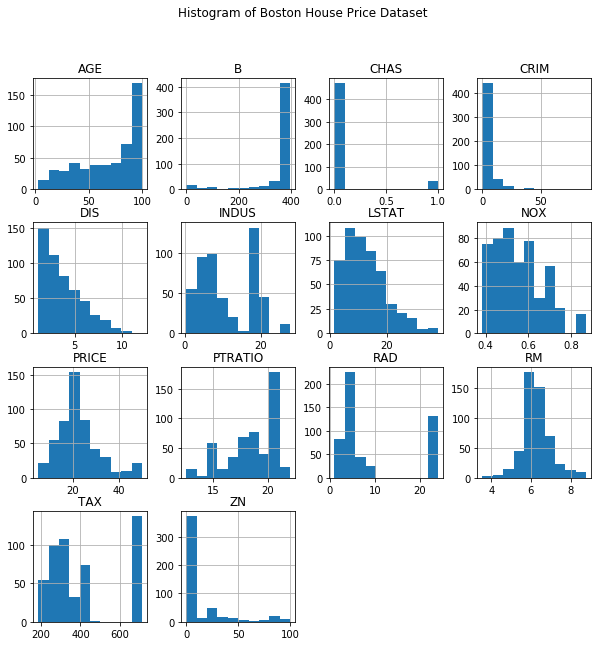

In [0]:
# plot histograms
data.hist()
plt.suptitle("Histogram of Boston House Price Dataset")
pass

In [0]:
# Pearson correlation coefficient with 'PRICE'
data.corr()['PRICE'].round(2).sort_values(ascending=False)

PRICE      1.00
RM         0.70
ZN         0.36
B          0.33
DIS        0.25
CHAS       0.18
RAD       -0.38
AGE       -0.38
CRIM      -0.39
NOX       -0.43
TAX       -0.47
INDUS     -0.48
PTRATIO   -0.51
LSTAT     -0.74
Name: PRICE, dtype: float64

### Data preparation

In [0]:
# select feature vector X (all data frame rows, all columns except "price") and label y (all rows, last column)
X, y = data.iloc[:, : -1], data.iloc[:,-1]

In [0]:
# confirm shape of X and y
print("Shape of feature vector: {}".format(X.shape))
print("Shape of target variable: {}".format(y.shape))

Shape of feature vector: (506, 13)
Shape of target variable: (506,)


In [0]:
# split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state = 42)

### Instantiate single regression tree

In [0]:
# instantiate decision tree regressor with impurity measure 'entropy' and regularization parameters 
# (e.g. max_depth, min_samples_split, max_leaf_nodes, min_samples_leaf)
clf = tree.DecisionTreeRegressor(criterion='mse', max_depth=5, 
                                  random_state=42, min_samples_split=10,
                                  max_leaf_nodes=10, min_samples_leaf=10)
clf = clf.fit(X_train, y_train)

In [0]:
y_pred = clf.predict(X_test)
rmse_tree = np.sqrt(np.mean((y_test - y_pred)**2))
print("RMSE of single regression tree on Boston House Price dataset: {}".format(rmse_tree))

RMSE of single regression tree on Boston House Price dataset: 4.605732300672347


*Evaluation metric: RMSE*

$$RMSE = \sqrt{\frac{\sum_{i}^{n} (y_i - \hat{y})^2}{n}}$$

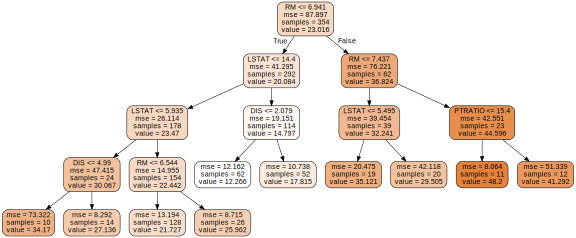

In [0]:
dot_data= tree.export_graphviz(clf, out_file=None, filled=True, rounded=True,
                               feature_names=data.columns[:-1])
# graph = graphviz.Source(dot_data) 

pdot = pydot.graph_from_dot_data(dot_data)
pdot[0].set_graph_defaults(size = "\"8,10\"")
graph = graphviz.Source(pdot[0].to_string())
graph

#### Output prediction for single example

In [0]:
# show first example
X_test.head(1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
173,0.09178,0.0,4.05,0.0,0.51,6.416,84.1,2.6463,5.0,296.0,16.6,395.5,9.04


In [0]:
# make prediction for first example
clf.predict(X_test)[0].round(2)

21.73

In [0]:
# show true value for first example
y_test.head(1)

173    23.6
Name: PRICE, dtype: float64

### Instantiate XGBoost regressor

In [0]:
# instantiate XGBoost regressor object, passing hyperparameters as arguments
# building 50 trees with maximum depth of 5, using only 30% of all features in each tree. L1 regularization (alpha = 10)
xg_reg = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=50, eval_metric= 'rmse', seed=42)

*XGBoost hyperparameter settings*


- `learning_rate`: step size shrinkage used to prevent overfitting. After each boosting step, we can directly get the weights of new features, and the leraning rate shrinks the feature weights to make the boosting process more conservative. Range is [0,1]
- `max_depth`: determines how deeply each tree is allowed to grow during any boosting round.
- `subsample`: percentage of samples used per tree. Low value can lead to underfitting.
- `colsample_bytree`: percentage of features used per tree. High value can lead to overfitting.
- `n_estimators`: number of trees you want to build.
- `objective`: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.


*XGBoost regularization parameters*

- `gamma`: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
-  `alpha`: L1 regularization on leaf weights. A large value leads to more regularization.
- `lambda`: L2 regularization on leaf weights and is smoother than L1 regularization.

In [0]:
# fit regressor to training set, make predictions on the test set
xg_reg.fit(X_train, y_train)
preds = xg_reg.predict(X_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
# compute metric RMSE (root mean squared error)
# rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse = np.sqrt(np.mean((y_test - preds)**2))
print("RMSE of XGBoost regression on Boston House Price dataset: {}".format(rmse))

RMSE of XGBoost regression on Boston House Price dataset: 3.3955520599493125


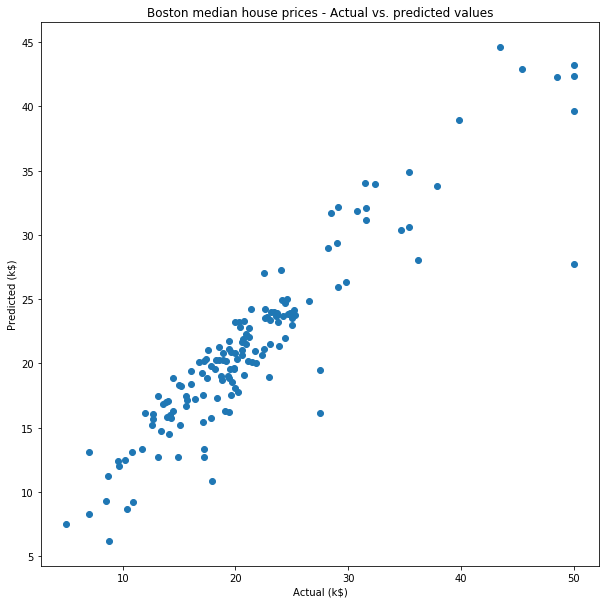

In [0]:
# plot actual and predicted values
plt.scatter(y_test, preds)
plt.xlabel('Actual (k$)')
plt.ylabel('Predicted (k$)')
plt.title('Boston median house prices - Actual vs. predicted values')
pass

### K-fold cross-validation using XGBoost

- `num_boost_round`: denotes the number of trees to build (analogous to n_estimators)
- `nfolds`: number of cross validation sets
- `early_stopping_rounds`: finishes training of the model early if the hold-out metric ("rmse" in our case) does not improve for a given number of rounds.


In [0]:
# convert dataset into XGBoost-supported format "DMatrix" (better performance)
data_matrix = xgb.DMatrix(data = X, label = y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [0]:
# dictionary to specify hyperparameters
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10}
# specify a 3-fold cross-validation model using the XGBoost cv method and store results in pandas dataframe
cv_results = xgb.cv(dtrain=data_matrix, params=params, nfold=3, num_boost_round=100,
                    early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=42)

In [0]:
# show first 10 boosting rounds
cv_results.head(10)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.677620,0.365537,21.657245,0.733362
1,19.765067,0.339690,19.762940,0.728698
2,18.043477,0.360459,18.016258,0.691769
3,16.430668,0.290129,16.481491,0.716878
4,15.030286,0.312868,15.102984,0.664057
5,13.759324,0.284932,13.875692,0.663240
6,12.607349,0.222135,12.780271,0.712663
7,11.578857,0.172315,11.842558,0.759246
8,10.713470,0.151068,11.007051,0.784776
9,9.876546,0.113080,10.182059,0.757334


In [0]:
# show last 10 boosting rounds
cv_results.tail(10)

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
90,1.664633,0.087142,3.890159,0.494351
91,1.657317,0.089047,3.885744,0.492953
92,1.651206,0.089865,3.885676,0.496333
93,1.645207,0.088133,3.881060,0.496798
94,1.634287,0.084960,3.874877,0.499641
95,1.632426,0.086368,3.874400,0.499594
96,1.627788,0.085705,3.871641,0.501472
97,1.621344,0.084626,3.870547,0.502301
98,1.609881,0.083571,3.864185,0.506027
99,1.603707,0.080725,3.862197,0.506766


In [0]:
# extract and print the final boosting round metric
print("Final boosting round RMSE: \n{}".format(cv_results["test-rmse-mean"].tail(1)))

Final boosting round RMSE: 
99    3.862197
Name: test-rmse-mean, dtype: float64


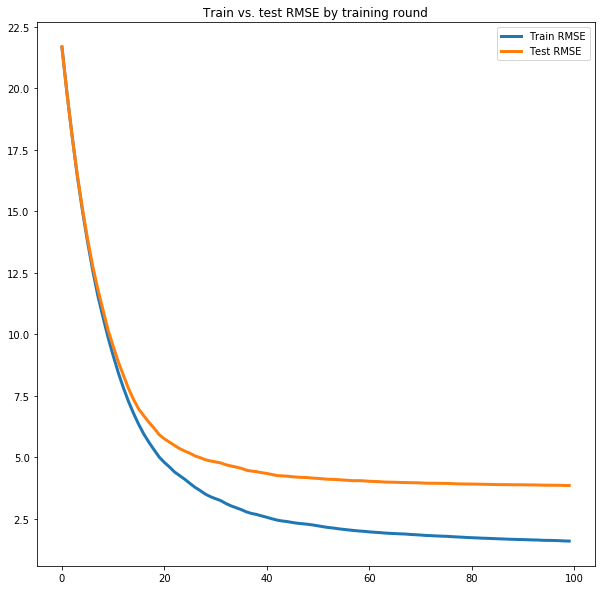

In [0]:
# plot train and test rmse
train_rmse = cv_results['train-rmse-mean']
test_rmse = cv_results['test-rmse-mean']
plt.plot(train_rmse, linewidth=3, label="Train RMSE")
plt.plot(test_rmse, linewidth=3, label='Test RMSE')
plt.legend()
plt.title("Train vs. test RMSE by training round")
pass

### Visualize trees and feature importance

In [0]:
xg_reg = xgb.train(params=params, dtrain=data_matrix, num_boost_round=50)

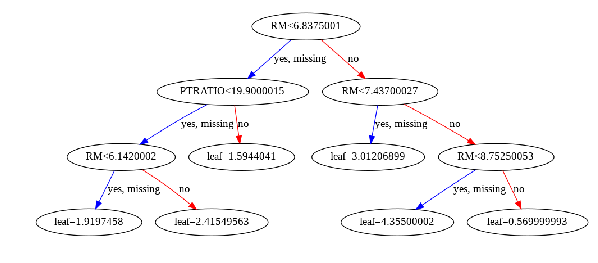

In [0]:
# Show first tree as an example (can see that XGBoost has discretized continuous features 
# by binning the ranges, pick cut points that gives the maximum entropy)
xgb.plot_tree(xg_reg, num_trees=0)
plt.show()

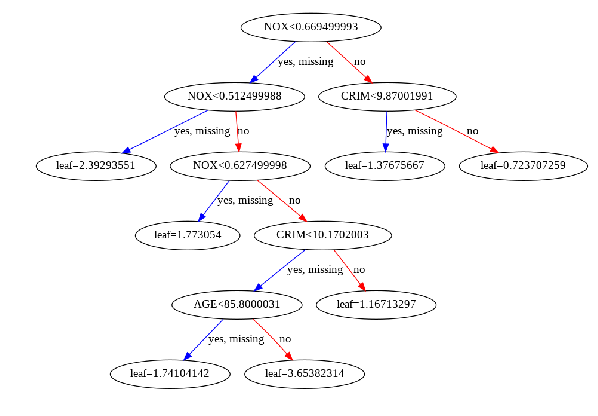

In [0]:
xgb.plot_tree(xg_reg, num_trees=1)
plt.show()

Unlike decision trees, each regression tree contains a continuous score on each of the leaf. For a given example, the decision rules of the tree will be used to classify it into the leaves and calculate the final prediction by summing up the scores in the corresponding leaves (across all trees).

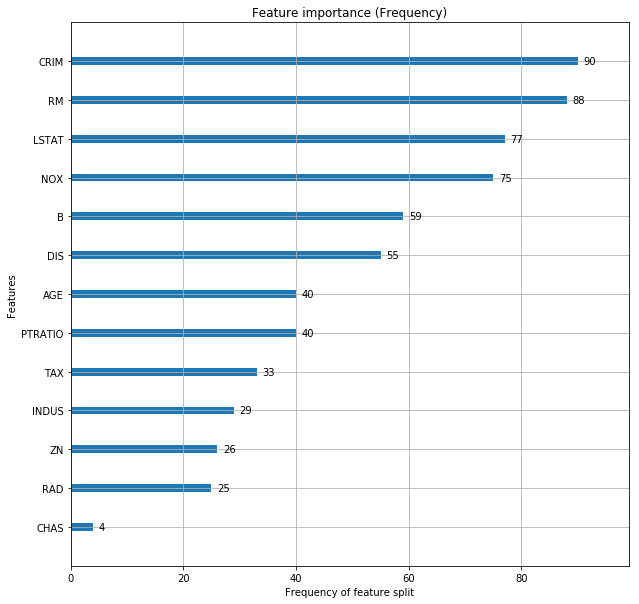

In [0]:
xgb.plot_importance(xg_reg, title="Feature importance (Frequency)", xlabel="Frequency of feature split")
# plt.rcParams['figure.figsize'] = [5, 5]
pass

*Frequency approach:*

Counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they are split on (sum over all trees).

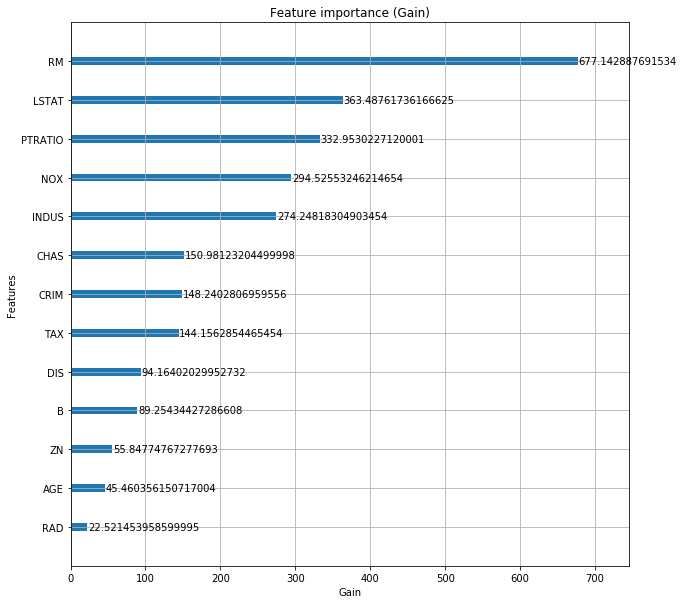

In [0]:
xgb.plot_importance(xg_reg, importance_type='gain', title="Feature importance (Gain)", xlabel='Gain')
pass

*Gain approach:*

Calculating the relative loss improvement (gain) of each feature on each non-terminal node of the boosted trees, and summing up.

### Summary

* Both algorithms predict Boston house prices on the test set with an RMSE of ca. 3,000 USD - 4,000 USD.
* On the Boston house price dataset, XGBoost outperforms single decision trees, with an RMSE difference of >1000 USD.
* Both for XGBoost as well as for single decision trees, tree splits were performed on features that were identified earlier during analysis of correlations (RM, LSTAT, PTRATIO).